# Aprendizaje Automático II - Trabajo Práctico 2: Clasificación de Audio

El presente notebook corresponde al trabajo práctico 2, problema 1 de la materia Aprendizaje Automático 2 de la Tecnicatura Universitaria en Inteligencia Artificial.

En el mismo se utilizarán los dataset: https://www.tensorflow.org/datasets/catalog/xtreme_s , el cual incluye diversos sub-datasets correspondientes a oraciones habladas en distintos idiomas. Utilizaremos un subconjunto de estos datasets para entrenar un clasificador de idiomas hablados.

Dado que el objetivo es la detección del idioma de los audios, se utilizarán los siguientes sub-conjutnos del dataset:

- Español: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleurses_419
- Inglés: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleursen_us
- Francés: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleursfr_fr
- Japonés: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleursja_jp

In [111]:
import warnings
warnings.filterwarnings('ignore')

## 0. Procesamiento de los audios

In [112]:
#importamos las librerías que utilizaremos para el preprocesamiento
from google.colab import drive
import os
from IPython.display import display, Audio
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

Primero, montamos el drive para contar con los datos.

In [113]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Y definimos las rutas de cada clase.

In [114]:
DATASET_ROOT = "drive/MyDrive/Datasets/dataset_reducido"
SPANISH_DATA = os.path.join(DATASET_ROOT, "español")
FRENCH_DATA = os.path.join(DATASET_ROOT, "frances")
ENGLISH_DATA = os.path.join(DATASET_ROOT, "ingles")
JAPANESE_DATA = os.path.join(DATASET_ROOT, "japones")

También definimos una función para poder escuchar los audios.

In [115]:
def escuchar(audio, sr):
  display(Audio(audio, autoplay=False, rate = sr))

### Longitud de los audios

A continuación, vemos la diferencia en las duraciones de los audios.

In [116]:
audios = []
audios_failed = []
for data in [SPANISH_DATA, FRENCH_DATA, ENGLISH_DATA, JAPANESE_DATA]:
  for fname in os.listdir(data):
    try:
      wav, sr = librosa.load(os.path.join(data, fname), sr=None)
      audios.append(wav)
    except:
      #print("\nError en el fichero: ", fname)
      audios_failed.append(fname)

min_duration = float("inf")
max_duration = 0
for audio in audios:
  if len(audio)/sr < min_duration:
    min_duration = len(audio)/sr
  if len(audio)/sr > max_duration:
    max_duration = len(audio)/sr


print("\nEl audio con duracion minima dura: ", min_duration, " segundos.")
print("El audio con duracion maxima dura: ", max_duration, " segundos.")


El audio con duracion minima dura:  4.14  segundos.
El audio con duracion maxima dura:  23.04  segundos.


Al observar la distribución de las longitudes o duraciones de los audios, observamos que la mayoría de los audios se encuentra en longitudes centrales que van desde aproximadamente los 7 segundos hasta los 16 segundos, por lo que no consideramos que sea conveniente simplemente extender los audios menores al maximo (22 segundos) con silencio, ya que la mayoría de cada audio quedaría en silencio.

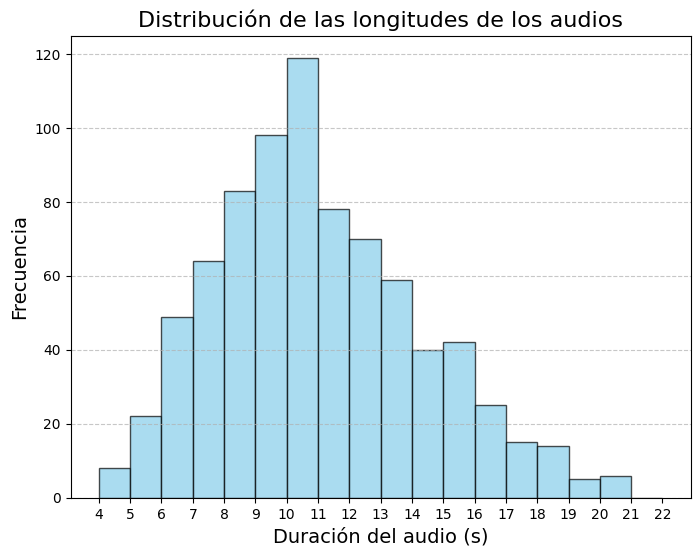

In [117]:
longitudes = []

for audio in audios:
  longitudes.append(len(audio)/16000)

bins = range(int(np.min(longitudes)), int(np.max(longitudes)))  # Incluye desde 4 hasta 20

# Crear el histograma
plt.figure(figsize=(8, 6))
plt.hist(longitudes, bins=bins, edgecolor='black', color='skyblue', alpha=0.7)

# Etiquetas y título
plt.title('Distribución de las longitudes de los audios', fontsize=16)
plt.xlabel('Duración del audio (s)', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks(bins)  # Mostrar cada duración en el eje x

# Mostrar la gráfica
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

El siguiente gráfico nos permite ver con mayor precisión qué longitudes tienen la mayoría de los audios:

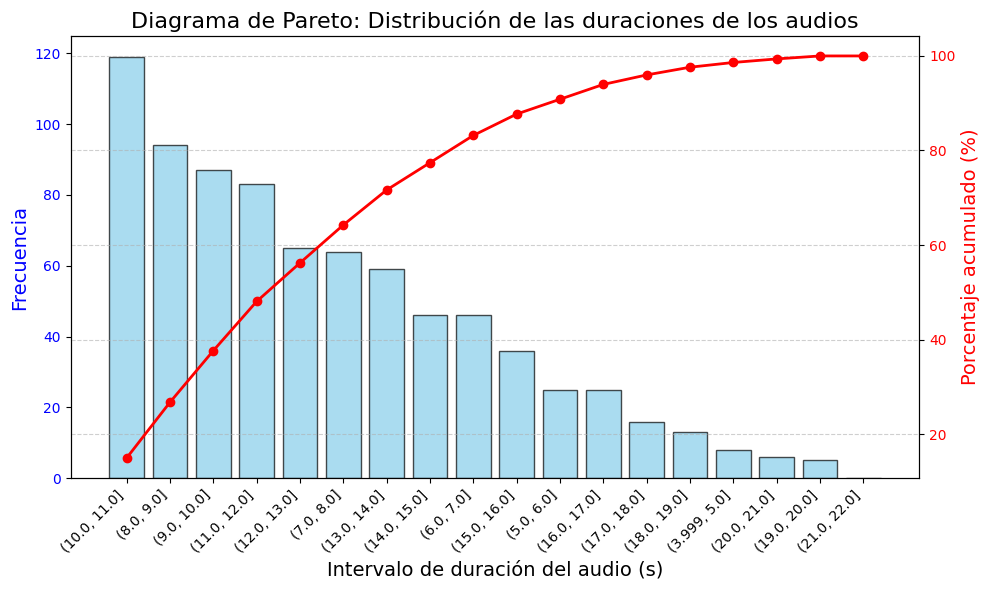

In [118]:
bins = range(int(np.min(longitudes)), int(np.max(longitudes)))  # De 4 a 20 segundos
hist, edges = np.histogram(longitudes, bins=bins)

df = pd.DataFrame({'longitudes':longitudes})
df['longitudes_discretizadas'] = pd.cut(df['longitudes'], bins=bins, include_lowest=True)

# Contar la frecuencia de aparición de cada intervalo
frequency = df['longitudes_discretizadas'].value_counts().sort_index(ascending=False)
frequency = frequency.sort_values(ascending=False)

# Calcular el porcentaje acumulado
cumulative_percentage = np.cumsum(frequency) / frequency.sum() * 100

# Crear el gráfico de Pareto
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de barras (frecuencia)
ax1.bar(frequency.index.astype(str), frequency, width=0.8, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Intervalo de duración del audio (s)', fontsize=14)
ax1.set_ylabel('Frecuencia', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Gráfico de línea (porcentaje acumulado)
ax2 = ax1.twinx()
ax2.plot(frequency.index.astype(str), cumulative_percentage, color='red', marker='o', linestyle='-', linewidth=2)
ax2.set_ylabel('Porcentaje acumulado (%)', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Título y configuración
plt.title('Diagrama de Pareto: Distribución de las duraciones de los audios', fontsize=16)
plt.xticks(rotation=70)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Observamos que más del 80% de los audios tiene una duración entre 6 segundos y 15 segundos. Por este motivo, nos quedaremos con solo estos audios y, para normalizar su duración, llenaremos los segundos que falte con silencio.

### Filtrado de audios

A continuación, nos quedamos solo con los audios que tienen una longitud de entre 6 y 15 segundos.

In [119]:
audios = []
categorias = []
audios_failed = []
for data in [SPANISH_DATA, FRENCH_DATA, ENGLISH_DATA, JAPANESE_DATA]:
  for fname in os.listdir(data):
    try:
      wav, sr = librosa.load(os.path.join(data, fname), sr=None)
      if data == SPANISH_DATA:
        audios.append(wav)
        categorias.append("español")
      elif data == FRENCH_DATA:
        audios.append(wav)
        categorias.append("frances")
      elif data == ENGLISH_DATA:
        audios.append(wav)
        categorias.append("ingles")
      else:
        audios.append(wav)
        categorias.append("japones")
    except:
      print("\nError en el fichero: ", fname)
      audios_failed.append(fname)


Error en el fichero:  206014402091929850.wav


In [120]:
df_audios = pd.DataFrame(zip(audios, categorias), columns = ['audio', 'idioma'])

In [121]:

audios_filtered = []
for audio in audios:
  if len(audio)/16000 >= 6 and len(audio)/16000 <= 15:
    audios_filtered.append(audio)

print("Nos quedamos con el ", round(len(audios_filtered)/len(audios)*100, 2), "% de los audios.")

Nos quedamos con el  83.35 % de los audios.


In [122]:
df_audios['duracion'] = df_audios['audio'].apply(lambda x: len(x)/16000)
df_audios

,audio,idioma,duracion
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",español,12.24
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",español,7.92
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",español,8.76
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",español,6.90
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",español,16.26
...,...,...,...
794,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",japones,7.08
795,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",japones,14.28
796,"[0.0, 0.0, -3.0517578e-05, -3.0517578e-05, -3....",japones,19.56
797,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",japones,13.32


In [123]:
df_filtered = df_audios[(df_audios['duracion'] >= 6) & (df_audios['duracion'] <= 15)]

In [124]:
proporcion = len(df_filtered.audio)/len(df_audios.audio)

print("Nos quedamos con el ", round(proporcion*100, 2), "% de los audios.")

Nos quedamos con el  83.35 % de los audios.


In [125]:
X = df_filtered.audio.to_list()
y = df_filtered.idioma

### Añadir padding con silencio a los audios

In [126]:
audios = X
max_length = 16*16000 #16 segundos por los 16000 mhz

# Añadir padding a los audios más cortos
audios_padded = []
for audio in audios:
    if len(audio) < max_length:
        audio = np.pad(audio, (0, max_length - len(audio)), mode='constant')
    audios_padded.append(audio)

In [127]:
#Comprobamos que todos tengan la misma longitud
for i in audios_padded:
  if len(i) != 16*16000:
    print(len(i))

In [128]:
X_padded = audios_padded

### Convertir a espectograma

Definimos dos funciones:
- ```get_spectogram```: obtiene un espectograma de una onda de audio dada.
- ```plot_spectogram```: grafica el espectograma pasado como argumento.

In [129]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Text(0.5, 1.0, 'Audio con espectograma')

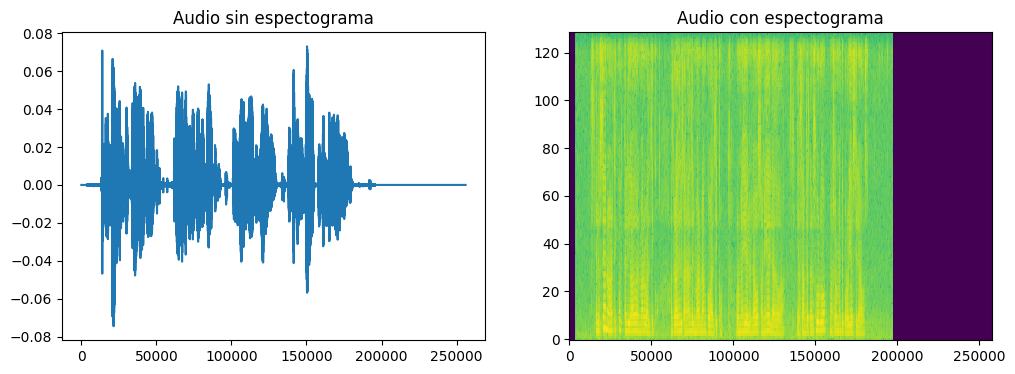

In [130]:
fig, ax = plt.subplots(1,2, figsize = (12, 4))

ax[0].plot(X_padded[0])
ax[0].set_title("Audio sin espectograma")

plot_spectrogram(get_spectrogram(X_padded[0]), ax[1])
ax[1].set_title("Audio con espectograma")

Por ultimo definimos nuestro conjunto X:

In [131]:
X_spectrogram = []
for audio in X_padded:
  X_spectrogram.append(get_spectrogram(audio))

X = np.array(X_spectrogram)

### Preparación de variable objetivo

Actualmente, las etiquetas de nuestros datos tienen el siguiente formato:


In [132]:
y

,idioma
0,español
1,español
2,español
3,español
6,español
...,...
793,japones
794,japones
795,japones
797,japones


Sin embargo, para entrenar una red neuronal debemos convertir las clases a un formato adecuado, para ello utilizamos LabelEncoder.

In [133]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Eliminación de Ruido

Tras un exhaustivo análisis logramos detectar que algunos audios presentaban catnidades excesivas de ruido en ellos, no permitiendo que se reconozca el idioma.

In [134]:
#Ojo el volumen
escuchar(X_padded[123], sr = sr)

Text(0.5, 1.0, 'Audio con espectograma')

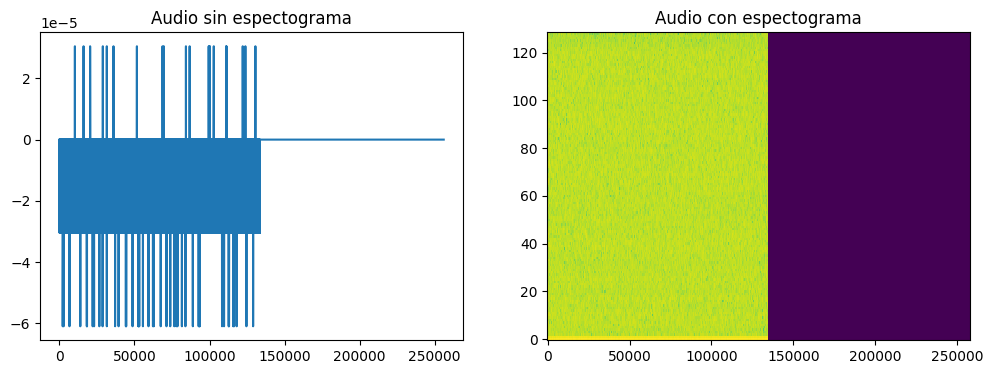

In [135]:
fig, ax = plt.subplots(1,2, figsize = (12, 4))

ax[0].plot(X_padded[123])
ax[0].set_title("Audio sin espectograma")

plot_spectrogram(get_spectrogram(X_padded[123]), ax[1])
ax[1].set_title("Audio con espectograma")

Para procesar intentar eliminar de nuestro conjunto de datos a estos datos con ruido, utilizamos el contraste espectral.

El contraste espectral considfera los picos espectrales, los valles espectrales, y sus diferencias en cada subbanda de frecuencia.

Un valor bajo del contraste espetral podría significar que el audio solo contiene ruido.

Empiricamente se comprobo que un umbral de 12 extrae unicamente audios con ruido.

In [136]:
import librosa.feature

In [137]:
audios_with_noise = []
audios_without_noise = []
for i, audio in enumerate(X_padded):
  contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
  avg_contrast = np.mean(contrast, axis=1)
  if avg_contrast.mean() < 12: #umbral definido empiricamente
    audios_with_noise.append((i, audio))
  else:
    audios_without_noise.append(audio)
print("Se agregaron ", len(audios_with_noise), " audios con ruido.")
print("Se conservaron ", len(audios_without_noise), " audios sin ruido.")

Se agregaron  22  audios con ruido.
Se conservaron  644  audios sin ruido.


In [138]:
indices = []
for audio in audios_with_noise:
  indices.append(audio[0])

X_without_noise = []

for i, audio in enumerate(X):
  if i not in indices:
    X_without_noise.append(audio)

y_without_noise = []
for i, label in enumerate(y_encoded):
  if i not in indices:
    y_without_noise.append(label)

Nos quedo un ligero desbalanceo en las clases, pero no consideramos que sea de importancia.

Text(0.5, 0, 'Clase')

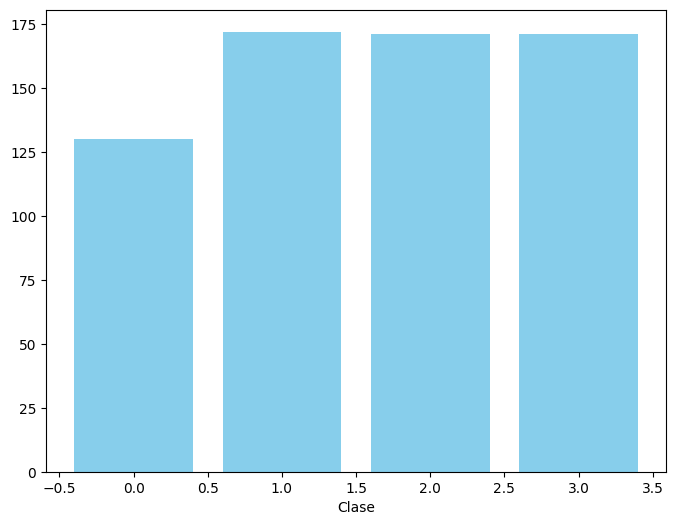

In [139]:
# Contar la frecuencia de aparición de cada clase
class_counts = {label: y_without_noise.count(label) for label in set(y_without_noise)}

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Clase')

In [140]:
y_encoded = np.array(y_without_noise)
X = np.array(X_without_noise)

## 1. División del Conjunto de Datos

In [141]:
# Dividimos el conjunto de datos en entrenamiento y pruebas
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                                  X,
                                                  np.array(y_encoded),
                                                  test_size=0.2,
                                                  shuffle=True
                                                  )

print("Longitud del subconjunto de entrenamiento: ", len(X_train))
print("Longitud del subconjunto de pruebas: ", len(X_test))

Longitud del subconjunto de entrenamiento:  515
Longitud del subconjunto de pruebas:  129


## 2. Construcción de Modelos

### Red Convolucional

In [142]:
input_shape = X_train[0].shape

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Resizing, Input, Flatten, Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

#Normalizacion
norm_layer = Normalization()

#Aplicar la normalizacion a cada registro
norm_layer.adapt(X_train)

model = Sequential([
    Input(shape=input_shape),
    Resizing(128, 128),
    #norm_layer,

    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=3),
    Dropout(0.5),

    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=3),
    Dropout(0.5),

    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=3),
    Dropout(0.5),

    Flatten(),
    Dense(4, activation='relu'),
    Dense(4, activation='relu'),
    Dense(4, activation='softmax')
])

from tensorflow.keras.optimizers import Adam

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compila el modelo con el optimizador personalizado
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2)

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_22 (Resizing)               │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 126, 126, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_94 (Dropout)                 │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 40, 40, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_95 (Dropout)                 │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 11, 11, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_96 (Dropout)                 │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 4)                   │           1,156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 4)                   │              20 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,548 (115.42 KB)

 Trainable params: 29,548 (115.42 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2705 - loss: 1.3864 - val_accuracy: 0.3010 - val_loss: 1.3859
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2809 - loss: 1.3792 - val_accuracy: 0.3107 - val_loss: 1.3853
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2876 - loss: 1.3832 - val_accuracy: 0.3301 - val_loss: 1.3835
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3480 - loss: 1.3769 - val_accuracy: 0.3495 - val_loss: 1.3801
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3049 - loss: 1.3643 - val_accuracy: 0.3301 - val_loss: 1.3745
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3667 - loss: 1.3621 - val_accuracy: 0.3786 - val_loss: 1.3732
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3537 - loss: 1.3605 - val_accuracy: 0.3786 - val_loss: 1.3741
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3212 - loss: 1.3614 - val_accuracy: 0.3495 - val_loss: 1

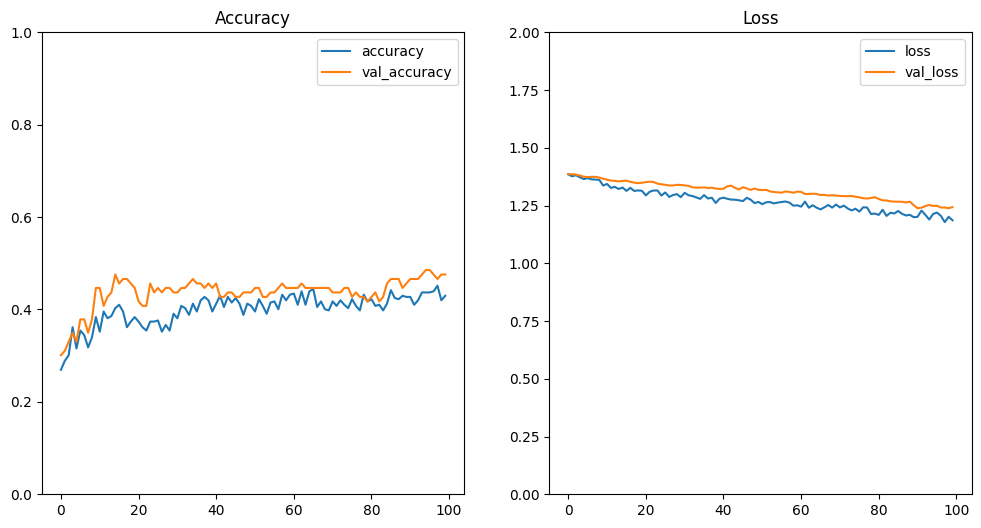

In [143]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear los gráficos
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de Accuracy
ax[0].plot(accuracy, label='accuracy')
ax[0].plot(val_accuracy, label='val_accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_ylim(0, 1)  # Ajustar la escala del eje Y de 0 a 1

# Gráfico de Loss
ax[1].plot(loss, label='loss')
ax[1].plot(val_loss, label='val_loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].set_ylim(0, 2)  # Ajustar la escala del eje Y de 0 a 1

# Mostrar los gráficos
plt.show()

### Red Recurrente

In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

In [145]:
# Fragmentar espectrogramas y transformar para una RNN
def process_for_rnn(X_train, fragment_length=500):
    X_train_rnn = []
    for spectrogram in X_train:
        # Remover el canal extra (ajustar de (1999, 129, 1) a (1999, 129))
        spectrogram = spectrogram.squeeze(-1)

        # Dividir el espectrograma en fragmentos de longitud 500
        num_fragments = spectrogram.shape[0] // fragment_length
        for i in range(num_fragments):
            fragment = spectrogram[i * fragment_length:(i + 1) * fragment_length, :]
            X_train_rnn.append(fragment)

    # Convertir la lista final a un array de NumPy
    return np.array(X_train_rnn)

# Aplicar la transformación
X_train_rnn = process_for_rnn(X_train)

# Verificar dimensiones finales
print(f"Forma original de X_train: {X_train.shape}")
print(f"Nueva forma de X_train_rnn: {X_train_rnn.shape}")

Forma original de X_train: (515, 1999, 129, 1)
Nueva forma de X_train_rnn: (1545, 500, 129)


Adaptamos train

In [146]:
# Ajustar etiquetas para coincidir con los fragmentos de X_train_rnn
def adjust_labels(y_train, num_fragments=3):
    y_train_rnn = []
    for label in y_train:
        # Repetir la etiqueta tantas veces como fragmentos por audio
        y_train_rnn.extend([label] * num_fragments)
    return np.array(y_train_rnn)

# Aplicar ajuste
y_train_rnn = adjust_labels(y_train, num_fragments=1999 // 500)

# Verificar dimensiones finales
print(f"Forma original de y_train: {y_train.shape}")
print(f"Forma ajustada de y_train_rnn: {y_train_rnn.shape}")

Forma original de y_train: (515,)
Forma ajustada de y_train_rnn: (1545,)


In [147]:

timesteps = X_train_rnn[0].shape[0]
features = X_train_rnn[0].shape[1]

# Crear el modelo
model = Sequential([
    Input(shape=(timesteps, features)),

    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=3),
    Dropout(0.5),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=3),
    Dropout(0.5),

    # Capa LSTM para modelar la secuencia temporal
    LSTM(64, return_sequences=False),
    Dropout(0.5),

    Dense(32, activation='relu'),
    Dense(4, activation='softmax')  # Salida para 4 clases
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)                   │ (None, 498, 64)             │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_40 (MaxPooling1D)      │ (None, 166, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_97 (Dropout)                 │ (None, 166, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_41 (Conv1D)                   │ (None, 164, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_41 (MaxPooling1D)      │ (None, 54, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_98 (Dropout)                 │ (None, 54, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_99 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,156 (395.14 KB)

 Trainable params: 101,156 (395.14 KB)

 Non-trainable params: 0 (0.00 B)

In [148]:
# Entrenar el modelo
history = model.fit(X_train_rnn, y_train_rnn, epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.2380 - loss: 1.3965 - val_accuracy: 0.3366 - val_loss: 1.3683
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3033 - loss: 1.3740 - val_accuracy: 0.3981 - val_loss: 1.3508
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3606 - loss: 1.3441 - val_accuracy: 0.3916 - val_loss: 1.3225
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3881 - loss: 1.3081 - val_accuracy: 0.4207 - val_loss: 1.2395
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4542 - loss: 1.2244 - val_accuracy: 0.4887 - val_loss: 1.1749
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4981 - loss: 1.1409 - val_accuracy: 0.5113 - val_loss: 1.1770
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5112 - loss: 1.1196 - val_accuracy: 0.5728 - val_loss: 1.0927
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5595 - loss: 1.0625 - val_accuracy: 0.

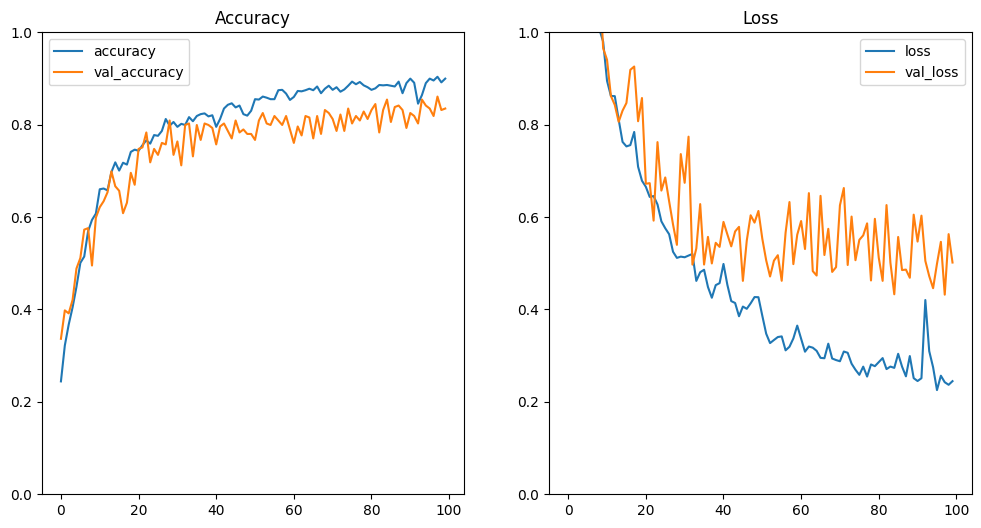

In [149]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Crear los gráficos
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de Accuracy
ax[0].plot(accuracy, label='accuracy')
ax[0].plot(val_accuracy, label='val_accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_ylim(0, 1)  # Ajustar la escala del eje Y de 0 a 1

# Gráfico de Loss
ax[1].plot(loss, label='loss')
ax[1].plot(val_loss, label='val_loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].set_ylim(0, 1)  # Ajustar la escala del eje Y de 0 a 1

# Mostrar los gráficos
plt.show()

In [150]:
X_test_rnn = process_for_rnn(X_test, 500)
y_test_rnn = adjust_labels(y_test, num_fragments=1999 // 500)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_rnn, y_test_rnn, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7969 - loss: 0.6391
Test Loss: 0.5154767036437988
Test Accuracy: 0.8191214203834534


# Conclusión

-----------

Podemos observar cómo las redes neuronales recurrentes se desempeñan de mejor manera cuando tratamos datos cuya dimensión temporal es de importancia.